In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

# Créer un exmple de dictionnaire
dictionary = {
    'name1': (5, 'date1', "It is so bad"),
    'name2': (4, 'date2', 'it sucks'),
    'name3': (3, 'date2', "It's okay"),
    'name4': (5, 'date2', 'It is very good'),
    'name5': (5, 'date2', "c'est un peu nul"),
    'name6': (5, 'date2', "The robot is very good"),
}

# Convertir le dictionnaire en DataFrame
df = pd.DataFrame(dictionary, index=['grading', 'date', 'Text']).T

df = df.reset_index().rename(columns={"index": "name"})
df = df.reset_index().rename(columns={"index": "ID"})

print(df)

   ID   name grading   date                    Text
0   0  name1       5  date1            It is so bad
1   1  name2       4  date2                it sucks
2   2  name3       3  date2               It's okay
3   3  name4       5  date2         It is very good
4   4  name5       5  date2        c'est un peu nul
5   5  name6       5  date2  The robot is very good


## EDA

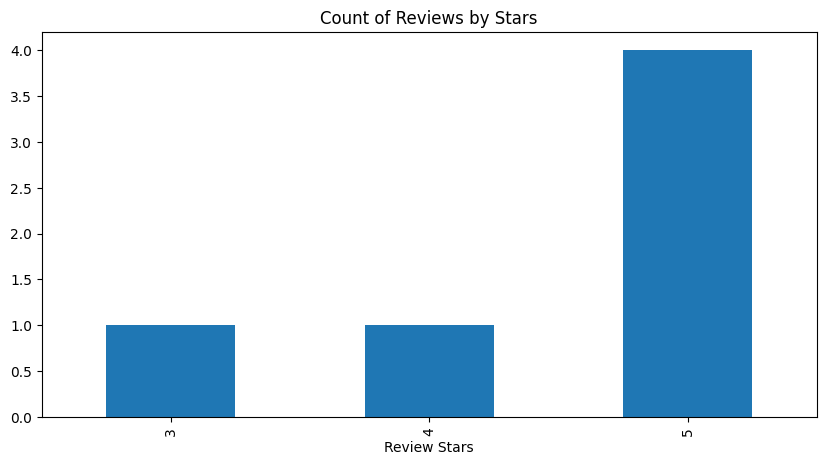

In [2]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [3]:
from transformers import pipeline

C:\Users\jacqu\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Sentiment Analysis with Roberta

nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    dict = pd.DataFrame(nlp(text))
    dict['ID'] = index
    res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})

# Merge the two dataframes
df = df.merge(res, left_on='ID', right_on='ID')
print(df)


C:\Users\jacqu\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jacqu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xform

   ID   name grading   date                    Text label (roberta)  \
0   0  name1       5  date1            It is so bad        NEGATIVE   
1   1  name2       4  date2                it sucks        NEGATIVE   
2   2  name3       3  date2               It's okay        POSITIVE   
3   3  name4       5  date2         It is very good        POSITIVE   
4   4  name5       5  date2        c'est un peu nul         NEUTRAL   
5   5  name6       5  date2  The robot is very good        POSITIVE   

   score (roberta)  
0         0.961788  
1         0.943688  
2         0.682161  
3         0.983293  
4         0.687441  
5         0.981288  


### Kaludi/Reviews-Sentiment-Analysis

In [5]:
# Pas de neutral dans le modèle Kaludi
# Ce modèle n'est pas très connu et j'ai pas l'impression qu'il soit très performant
nlp = pipeline("sentiment-analysis", model=f"Kaludi/Reviews-Sentiment-Analysis")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    dict = pd.DataFrame(nlp(text))
    dict['ID'] = index
    res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (rev)", "score": "score (rev)"})

# Merge the two dataframes
df = df.merge(res, left_on='ID', right_on='ID')
print(df)


   ID   name grading   date                    Text label (roberta)  \
0   0  name1       5  date1            It is so bad        NEGATIVE   
1   1  name2       4  date2                it sucks        NEGATIVE   
2   2  name3       3  date2               It's okay        POSITIVE   
3   3  name4       5  date2         It is very good        POSITIVE   
4   4  name5       5  date2        c'est un peu nul         NEUTRAL   
5   5  name6       5  date2  The robot is very good        POSITIVE   

   score (roberta) label (rev)  score (rev)  
0         0.961788    Negative     0.977560  
1         0.943688    Negative     0.526841  
2         0.682161    Positive     0.733796  
3         0.983293    Positive     0.950893  
4         0.687441    Positive     0.762750  
5         0.981288    Positive     0.959777  


## nlptown/bert-base-multilingual-uncased-sentiment

In [6]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu

nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    dict = pd.DataFrame(nlp(text))
    dict['ID'] = index
    res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (Bert), over 5", "score": "score (Bert)"})

# Merge the two dataframes
df = df.merge(res, left_on='ID', right_on='ID')
print(df)


   ID   name grading   date                    Text label (roberta)  \
0   0  name1       5  date1            It is so bad        NEGATIVE   
1   1  name2       4  date2                it sucks        NEGATIVE   
2   2  name3       3  date2               It's okay        POSITIVE   
3   3  name4       5  date2         It is very good        POSITIVE   
4   4  name5       5  date2        c'est un peu nul         NEUTRAL   
5   5  name6       5  date2  The robot is very good        POSITIVE   

   score (roberta) label (rev)  score (rev)  label (Bert), over 5  \
0         0.961788    Negative     0.977560                     1   
1         0.943688    Negative     0.526841                     1   
2         0.682161    Positive     0.733796                     3   
3         0.983293    Positive     0.950893                     5   
4         0.687441    Positive     0.762750                     2   
5         0.981288    Positive     0.959777                     5   

   score (Bert)  


## Comparaison des modèles